# IMU Calibration

As discussed the typical IMU sensor model can be expressed as 

$$
\tilde{a} = b + (I+M) a + \eta 
$$

Where $b$ is bias vector and $M$ is a scaling, cross-coupling matrix. In this exercise, we'll introduce an IMU model misaligned from the object and perform calibration to obtain the $M$ and $b$ values. 

**Note:**
* We cannot use the loop shape path for calibration purposes as acceleration components needs to be linearly independent of each other. 
* Roll, pitch and yaw angles are set to 0.

The state vector for the object can be expressed as $X=[x,y,z,\theta,\phi,\dot{x},\dot{y},\dot{z}]$.

<img src="Drone3D2.png" width="600">

In [1]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

import numpy as np 
from math import sin, cos, tan
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from mpl_toolkits.mplot3d import Axes3D
import jdc
import random
from calibrating_object import ObjectInThreeD
from misalignment_calibration import flight_path

pylab.rcParams['figure.figsize'] = 10, 10

First, let's generate a calibration path where the acceleration components are linearly independent.

In [2]:
t, dt, x, x_dot, x_dot_dot, y, y_dot, y_dot_dot, z, z_dot, z_dot_dot, phi, phi_dot, theta, theta_dot = flight_path()

Plotting the path that drone takes for calibration.

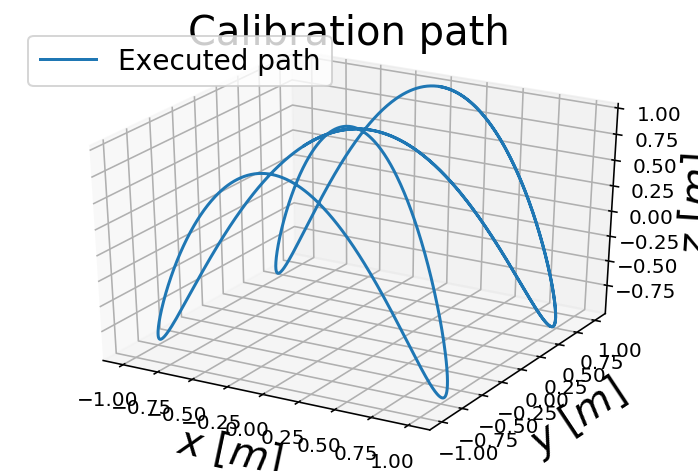

In [3]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(x, y, z)
plt.title('Calibration path').set_fontsize(20)
ax.set_xlabel('$x$ [$m$]').set_fontsize(20)
ax.set_ylabel('$y$ [$m$]').set_fontsize(20)
ax.set_zlabel('$z$ [$m$]').set_fontsize(20)
plt.legend(['Executed path'],fontsize = 14)

plt.show()

# IMU 

You'll notice `scaling_cross_coupling_matrix` is integrated into the acceleration measurement.

In [4]:
class IMU:
    
    def __init__(self,
                 sigma_a = 0.0001,          # An error of acceleration measurement
                ):
        '''
        Initializing the IMU object with the sigma values associated 
        to the measuring the accelerations in the body frame.
        '''
        self.sigma_a  = sigma_a
        self.g = 9.81 * np.array([[0], [0], [-1]]) # The opposite of the gravity thus directed opposite of the z-axis. 
    
    def rotation_matrix(self,phi,theta):
        '''
        Returns the rotation matrix for the given roll, pitch and yaw angles 
        '''
        
        psi = 0.0 
        r_x = np.array([[1, 0, 0],
                        [0, np.cos(phi), -np.sin(phi)],
                        [0, np.sin(phi), np.cos(phi)]])

        r_y = np.array([[np.cos(theta), 0, np.sin(theta)],
                        [0, 1, 0],
                        [-np.sin(theta), 0, np.cos(theta)]])

        r_z = np.array([[np.cos(psi), -np.sin(psi), 0],
                        [np.sin(psi), np.cos(psi), 0],
                        [0,0,1]])

        r = np.matmul(r_z,np.matmul(r_y,r_x))

        return r 
    
    @property
    def scaling_cross_coupling_matrix(self):
        '''
        scaling cross-coupling matrix which can characterize the accelerometer measurements
        '''

        m = np.array([[0.0, 0.001, 0.001],
                      [0.001, 0.0, 0.001],
                      [0.001, 0.001, 0.0]])

        return m
    
    def accelerometer_measurement(self, actual_a, phi, theta):
        '''
        Simulates the measurements of the accelerations in the body frame 
        based on the actual linear acceleration.
        We kept the accelerometer measurement implementation developed in the previous exercise.
        '''
        
        actual_a = actual_a.reshape(3, 1)
        linear_acc_bodyframe = np.matmul(self.rotation_matrix(phi, theta), actual_a)
        
        gravity_component = np.matmul(self.rotation_matrix(phi, theta), self.g)
        
        error_component = np.random.normal(0.0, self.sigma_a, (3, 1))

        # TODO: calculate the measured acceleration using the scaling cross-coupling matrix
        measured_acceleration = np.matmul((np.identity(3) + self.scaling_cross_coupling_matrix),
                                      (linear_acc_bodyframe + gravity_component)) + error_component
    

        return measured_acceleration
    

Now we are ready to execute calibration motion and capture the accelerations recorded by the IMU.

In [10]:
MisalignedIMU =IMU(sigma_a=0.0001)
CalibrationObject = ObjectInThreeD(dt)
CalibrationObject.X = np.array([x[0], y[0], z[0], theta[0], phi[0], x_dot[0], y_dot[0], z_dot[0]])

state_histroy = CalibrationObject.X 
actual_a = np.vstack((np.vstack((x_dot_dot, y_dot_dot)), z_dot_dot))
measured_acceleration = MisalignedIMU.accelerometer_measurement(actual_a[:,0], phi[0], theta[0])
measured_acceleration_history=measured_acceleration

for i in range(phi.shape[0]):
    measured_acceleration = MisalignedIMU.accelerometer_measurement(actual_a[:,i], phi[i], theta[i])
    p, q = 0, 0 
    
    state_of_drone = CalibrationObject.advance_state(measured_acceleration, p, q, dt)
    state_histroy = np.vstack((state_histroy,state_of_drone))
    measured_acceleration_history = np.hstack((measured_acceleration_history,measured_acceleration))


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)

Comparing the calibration path with the inferred path.

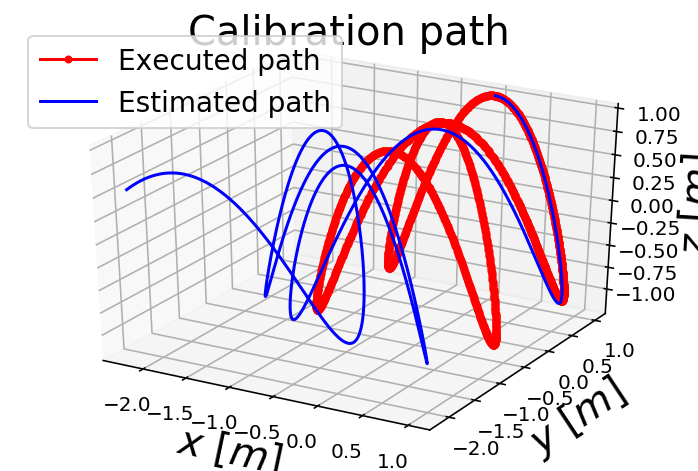

In [6]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(x, y, z,color ='red', marker='.')
ax.plot(state_histroy[:,0], state_histroy[:,1], state_histroy[:,2], color ='blue')
plt.title('Calibration path').set_fontsize(20)
ax.set_xlabel('$x$ [$m$]').set_fontsize(20)
ax.set_ylabel('$y$ [$m$]').set_fontsize(20)
ax.set_zlabel('$z$ [$m$]').set_fontsize(20)
plt.legend(['Executed path','Estimated path'], fontsize = 14)

plt.show()

### Calculating the $M$ matrix

A function, $y$, which is a linear combination of several independent variables $x_1 ... x_n$ can be expressed as: 

$$
y= c_0 + c_1 x_1 + c_2 x_2 + ... + c_n x_n 
$$

Knowing $y$ for each set of $x_1 ... x_n$ least squares can be used to calculate the coefficients values $c_0, c_1, ..., c_n$.

In our case, $\tilde{a} \equiv y $ and $a_x, a_y, a_z \equiv x_1, x_2, x_3$ 
Least Squares can be performed using [`np.linalg.lstsq`](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.lstsq.html) and it will have to be performed for each acceleration component separately to obtain elements for the proper bias and scaling cross-coupling matrix rows. 

In [9]:
estimated_scaling_cross_coupling_matrix_and_bias=np.zeros((3,4))
# TODO: Add a row of 1s to the actual acceleration matrix.
acceleration_vectors=np.vstack([actual_a, np.ones(actual_a.shape[1])])

# TODO: Perform least squares for each acceleration components. 
for i in range(3):
    estimated_scaling_cross_coupling_matrix_and_bias[i,:] = np.linalg.lstsq(acceleration_vectors.T,
                                                                            measured_acceleration_history[i, 1:])[0]
    
print('(I+M) =  \n',estimated_scaling_cross_coupling_matrix_and_bias)

(I+M) =  
 [[ 1.00000219e+00  1.00349275e-03  1.00042993e-03 -9.81364288e-03]
 [ 1.00320687e-03  9.99994566e-01  1.00030506e-03 -9.81037698e-03]
 [ 9.89924368e-04  9.98806379e-04  1.00000142e+00 -9.80999713e+00]]


/Users/minhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


As you can see the given method was able to capture the linear scaling terms on (diagonal elements) which are reasonably close to one. As $(I+M)$ matrix will result in the diagonal terms close to one. Also, it was able to estimate off-diagonal elements with good precision. Finally, we can see that the bias elements the final column of the obtained matrix contains the gravity constant for the $z$ component. This is not characteristic of the IMU unit but, since we have not removed it artificially, as expected it shows up as the bias. 